In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import seaborn as sns

In [2]:
train_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv")
train_data.head()

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg


In [3]:
test_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv")
test_data.head()

,uniqueID,imageFile
0,1,facd4dcd8e869617.jpg
1,9,78c96bb2b2b62579.jpg
2,10,d292d2c4e0e6ad9d.jpg
3,14,3633494929870713.jpg
4,16,dc94b496c8e2d6c4.jpg


In [4]:
val_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv")
val_data.head()

,uniqueID,classLabel,classID,source,imageFile
0,7,microscope-slides,6,K,f09a8abe9e9e9ef2.jpg
1,20,illustrations-color,2,BHL,a6c6868387c6af8c.jpg
2,37,ordinary-pressed-specimens,9,YU,6062c68e8c34b292.jpg
3,59,animal-specimens,0,CAS,363617271597dfd9.jpg
4,60,biocultural-specimens,1,Met,4218d8d2f42b05e4.jpg


In [5]:
train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'
val_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'

## Check Class Imbalance

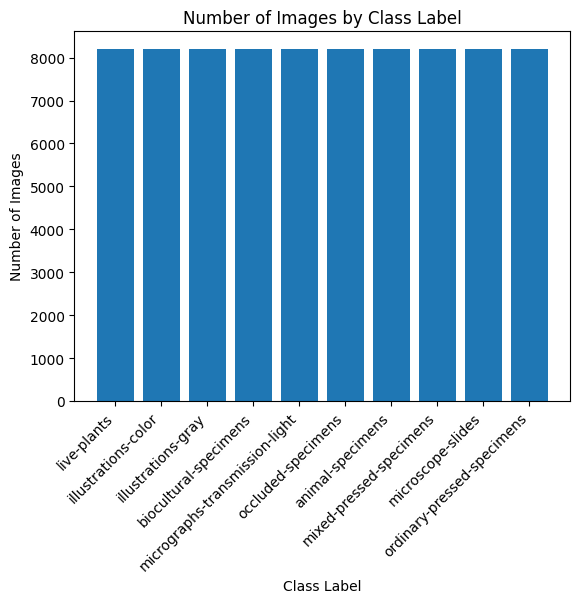

In [6]:
# Group by 'classLabel' and count the number of images in each class
class_counts = train_data['classLabel'].value_counts()

# Plotting 
plt.bar(class_counts.index, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images by Class Label')
plt.xticks(rotation=45, ha='right')  
plt.show()

In [7]:
print(class_counts)

classLabel
live-plants                       8200
illustrations-color               8196
illustrations-gray                8196
biocultural-specimens             8195
micrographs-transmission-light    8195
occluded-specimens                8194
animal-specimens                  8194
mixed-pressed-specimens           8193
microscope-slides                 8192
ordinary-pressed-specimens        8191
Name: count, dtype: int64


The dataset is relatively balanced, with each class containing approximately 8200 images.

## Source

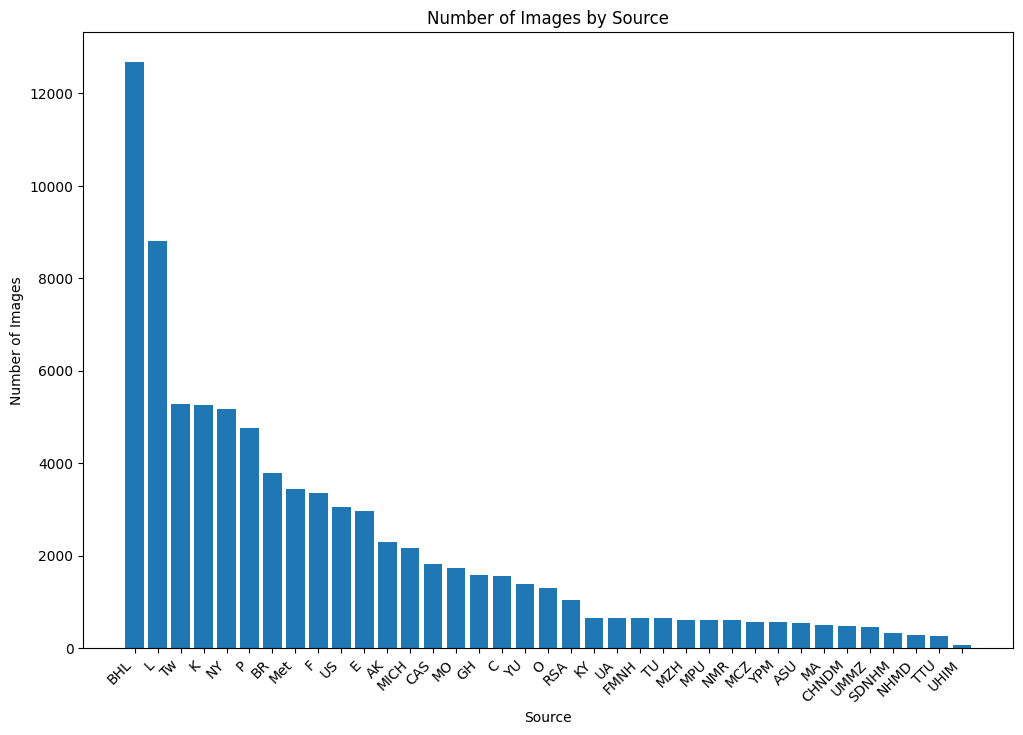

In [8]:
# Group by 'source' and count the number of images
source_counts = train_data['source'].value_counts()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(source_counts.index, source_counts)
plt.title('Number of Images by Source')
plt.xlabel('Source')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  
plt.show()

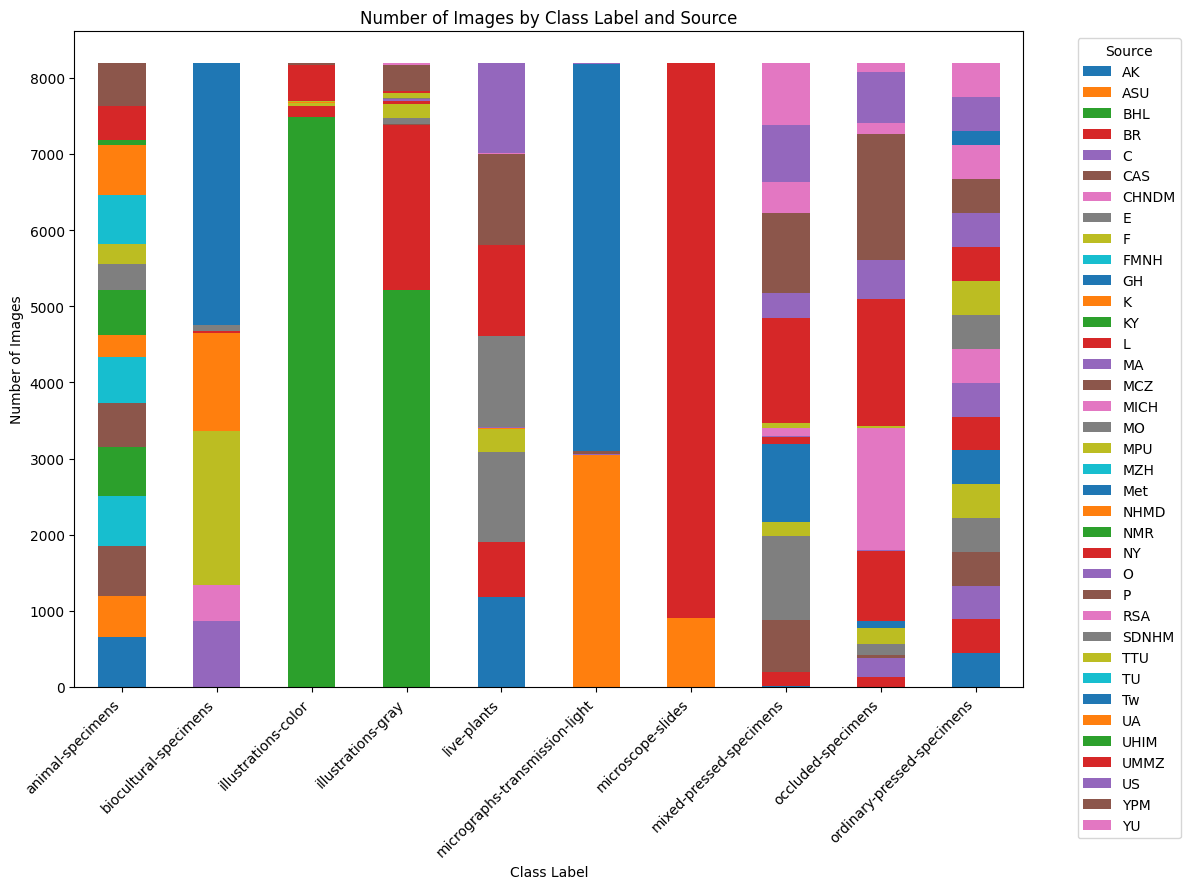

In [9]:
# Group by 'classLabel' and 'source' and count the number of images in each group
class_source_counts = train_data.groupby(['classLabel', 'source']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 9))  
class_source_counts.plot(kind='bar', stacked=True, ax=plt.gca())  

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images by Class Label and Source')
plt.xticks(rotation=45, ha='right')  
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

The sources of the images are distributed randomly, and there doesn’t appear to be a correlation with the class labels. However, the categories ‘illustrations-color’ and ‘microscope-slides’ are predominantly made up of images from a single source.

## Visualization

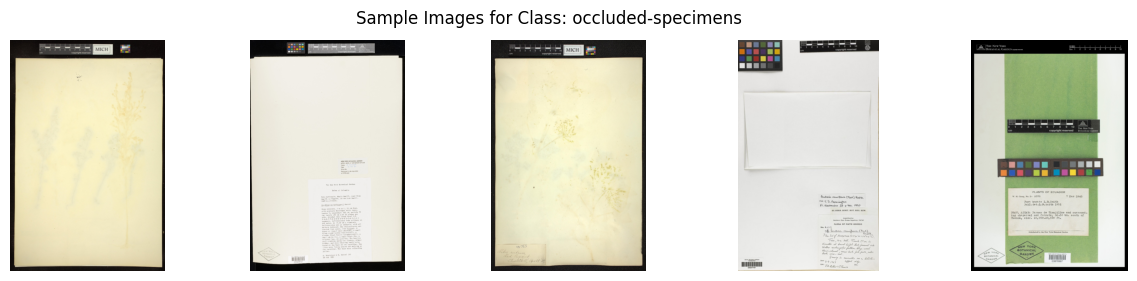

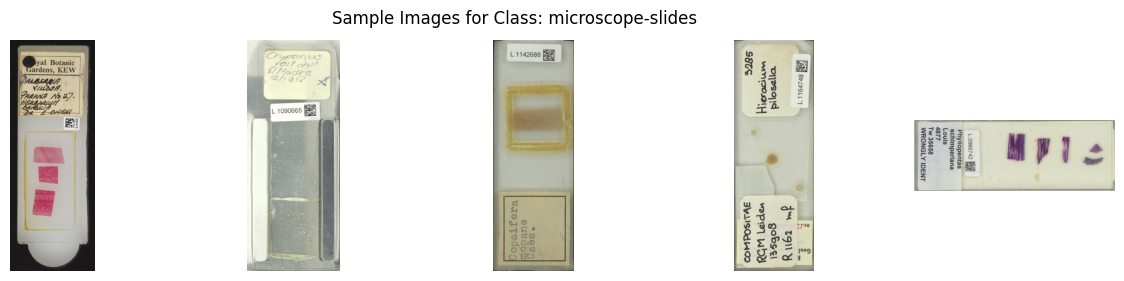

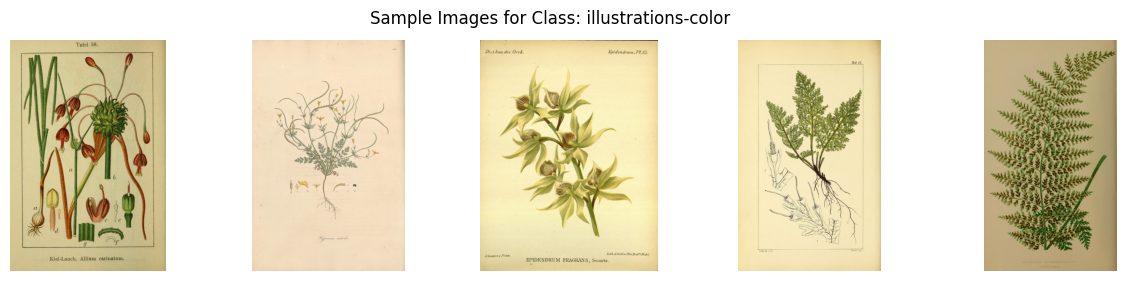

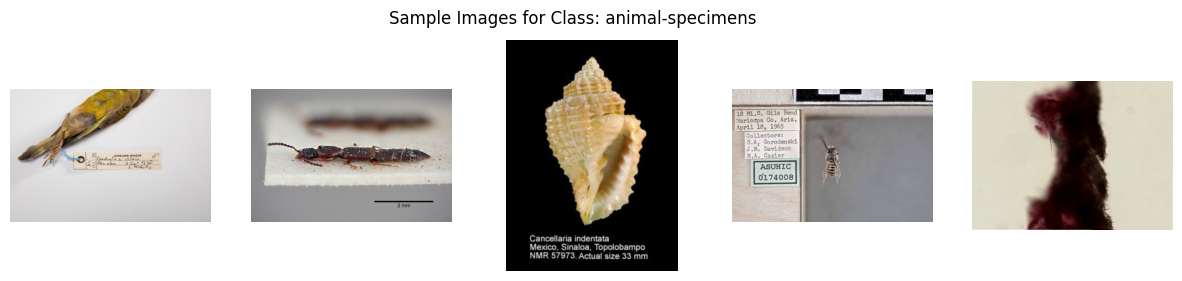

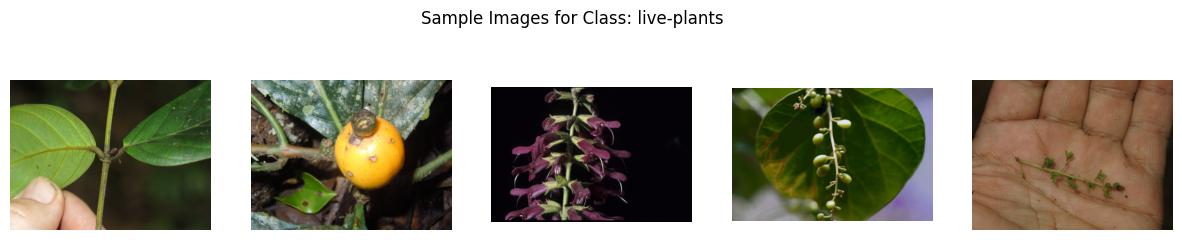

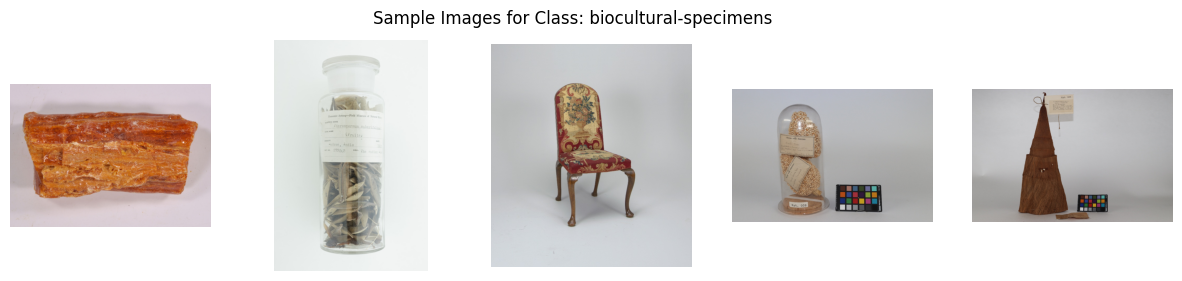

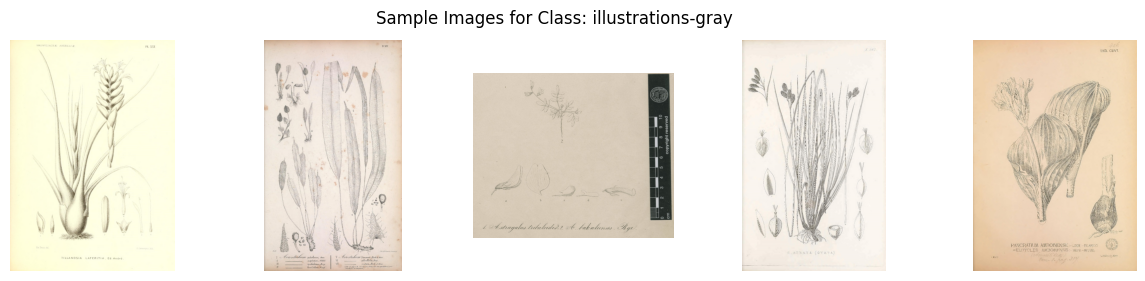

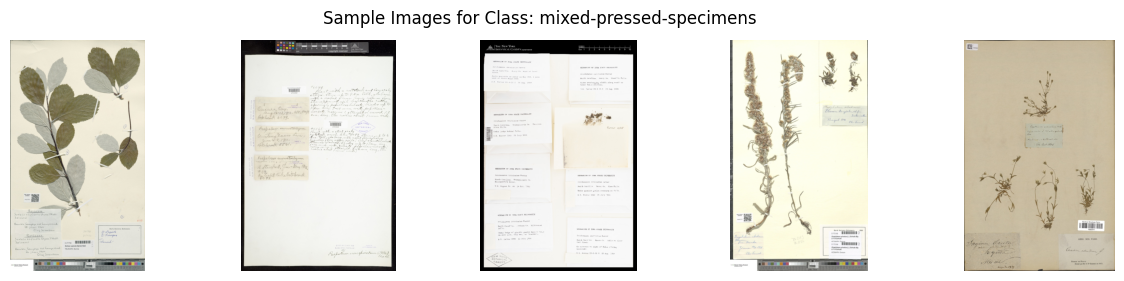

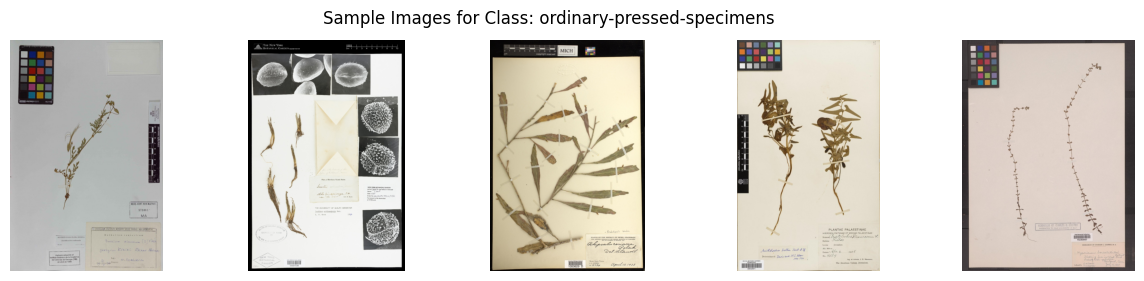

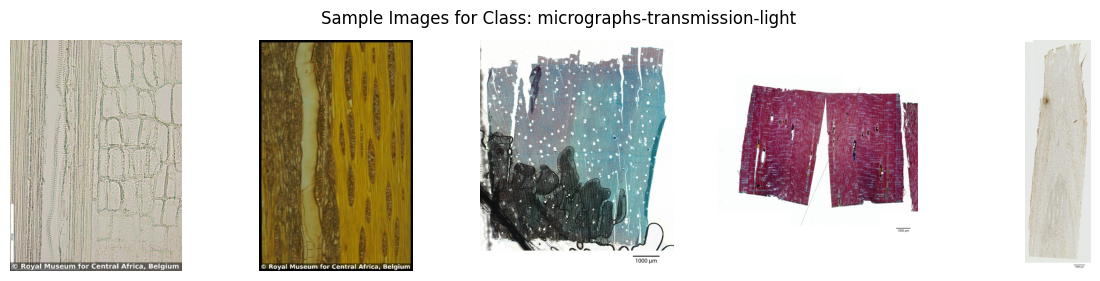

In [10]:
# Sample image visualization
def display_sample_images(df, train_dir, num_images=5):
    classes = df['classLabel'].unique()

    for class_label in classes:
        sample_images = df[df['classLabel'] == class_label]['imageFile'].sample(num_images).values

        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Sample Images for Class: {class_label}')

        for i, image_file in enumerate(sample_images):
            image_path = os.path.join(train_dir, image_file)
            plt.subplot(1, num_images, i + 1)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

display_sample_images(train_data, train_dir)

## Image Size Distribution

In [11]:
!pip install imagesize

Processing images: 100%|██████████| 81946/81946 [07:38<00:00, 178.62it/s]


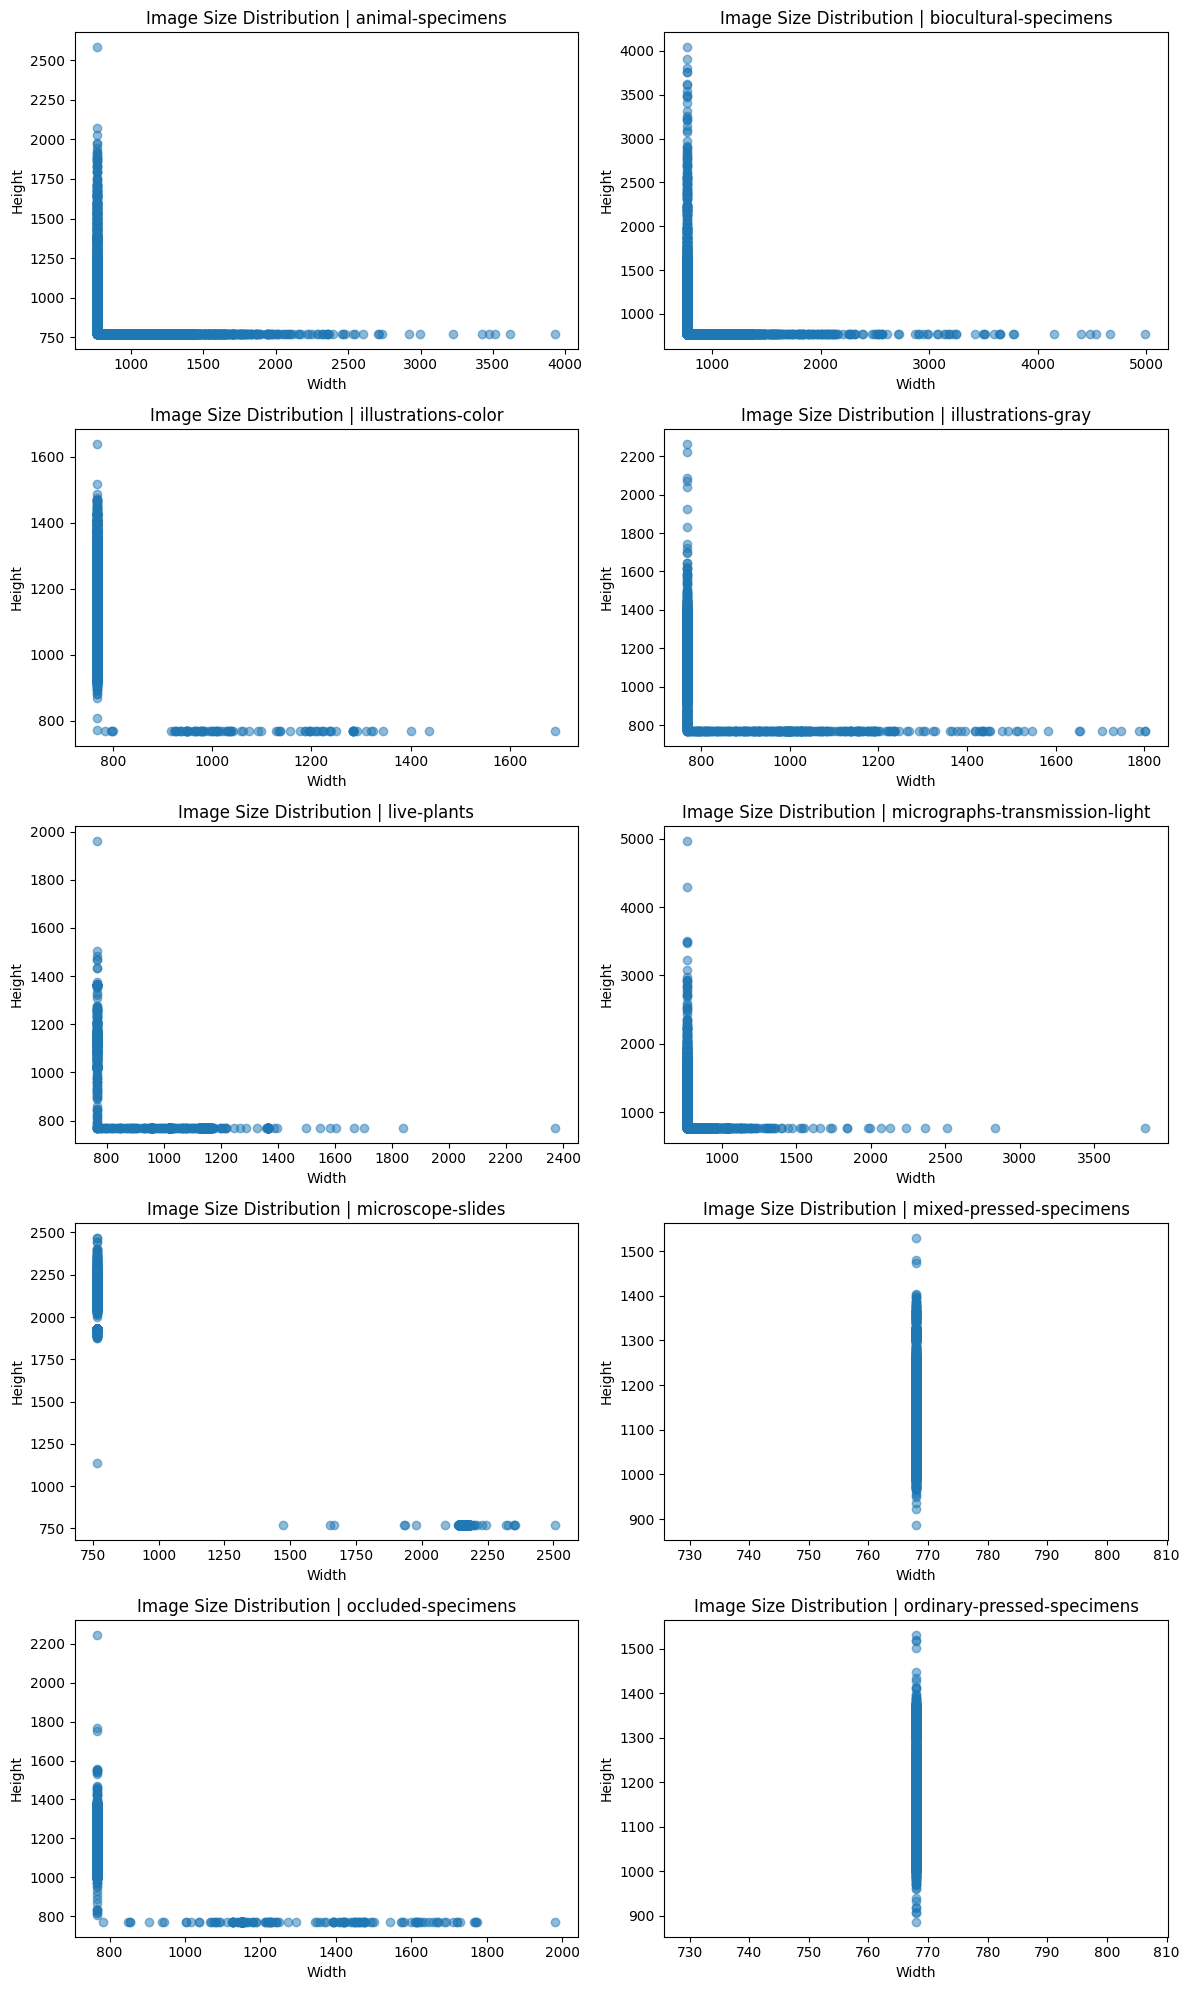

In [12]:
from concurrent.futures import ThreadPoolExecutor
import imagesize

# Function to get image size using imagesize
def get_image_size(image_path):
    image_path = os.path.join(train_dir, image_path)
    return imagesize.get(image_path)

# Add columns for width and height to the DataFrame
tqdm.pandas(desc="Processing images")
train_data[['width', 'height']] = pd.DataFrame(train_data['imageFile'].progress_apply(get_image_size).tolist(), index=train_data.index)

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

# Plot image size distribution for each class label
for (class_label, group), ax in zip(train_data.groupby('classLabel'), axes.flatten()):
    ax.scatter(group['width'], group['height'], alpha=0.5)
    ax.set_title(f'Image Size Distribution | {class_label}')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()